In [10]:
# ==============================================================================
# OLIST RFM INTELLIGENCE ENGINE (FINAL ULTIMATE)
# Features: K-Means vs GMM Battle | Strict Business Labeling | Production-Ready
# ==============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.decomposition import PCA

sns.set_style("whitegrid")
np.random.seed(42)

In [11]:
# ==============================================================================
# 1. LOAD & MERGE DATA
# ==============================================================================
print("\n[1/10] Loading Olist data...")

orders = pd.read_csv("olist_orders_dataset.csv")
items = pd.read_csv("olist_order_items_dataset.csv")
customers = pd.read_csv("olist_customers_dataset.csv")

orders = orders[orders["order_status"] == "delivered"]

df = (
    orders
    .merge(items, on="order_id", how="left")
    .merge(customers, on="customer_id", how="left")
)

df["purchase_date"] = pd.to_datetime(df["order_purchase_timestamp"])
df["revenue"] = df["price"] + df["freight_value"]


[1/10] Loading Olist data...


In [12]:
# ==============================================================================
# 2. RFM FEATURE ENGINEERING
# ==============================================================================
print("[2/10] Computing RFM metrics...")

SNAPSHOT_DATE = df["purchase_date"].max() + pd.Timedelta(days=1)

rfm = (
    df.groupby("customer_unique_id")
    .agg({
        "purchase_date": lambda x: (SNAPSHOT_DATE - x.max()).days,
        "order_id": "nunique",
        "revenue": "sum"
    })
    .reset_index()
)

rfm.columns = ["customer_id", "Recency", "Frequency", "Monetary"]

# --- OUTLIER CONTROL (Top 1% Extreme Whales removed) ---
cap_m = rfm["Monetary"].quantile(0.99)
rfm = rfm[rfm["Monetary"] <= cap_m]

[2/10] Computing RFM metrics...


In [13]:
# ==============================================================================
# 3. SCALING
# ==============================================================================
print("[3/10] Scaling features...")

scaler = StandardScaler()
X_scaled = scaler.fit_transform(rfm[["Recency", "Frequency", "Monetary"]])

[3/10] Scaling features...


In [14]:
# ==============================================================================
# 4. DETERMINING OPTIMAL K (Using K-Means Logic)
# ==============================================================================
print("[4/10] Determining Optimal K (Sampled)...")

# Use sampling for speed
sample_size = min(10000, len(X_scaled))
idx = np.random.choice(len(X_scaled), sample_size, replace=False)
X_sample = X_scaled[idx]

metrics = {}

for k in range(3, 7): # Test 3 to 6 clusters
    km = KMeans(n_clusters=k, random_state=42, n_init=15)
    labels = km.fit_predict(X_sample)
    sil = silhouette_score(X_sample, labels)
    dbi = davies_bouldin_score(X_sample, labels)
    metrics[k] = (sil, dbi)
    print(f"   k={k} | Sil={sil:.4f} | DBI={dbi:.4f}")

# Select best K based on Max Silhouette (primary) & Min DBI (secondary)
best_k = max(metrics, key=lambda k: (metrics[k][0], -metrics[k][1]))
print(f">>> Optimal K selected: {best_k}")

[4/10] Determining Optimal K (Sampled)...
   k=3 | Sil=0.4051 | DBI=0.8508
   k=4 | Sil=0.4612 | DBI=0.7166
   k=5 | Sil=0.3832 | DBI=0.8074
   k=6 | Sil=0.4047 | DBI=0.7474
>>> Optimal K selected: 4


In [15]:
# ==============================================================================
# 5. MODEL BATTLE: K-MEANS vs GMM (NEW MODULE)
# ==============================================================================
print(f"\n[5/10] Running Model Battle (K-Means vs GMM) with k={best_k}...")

# --- A. Train K-Means ---
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=30)
labels_km = kmeans.fit_predict(X_scaled)
# Calc metrics on sample for fairness
labels_km_sample = labels_km[idx]
sil_km = silhouette_score(X_sample, labels_km_sample)
dbi_km = davies_bouldin_score(X_sample, labels_km_sample)

# --- B. Train GMM ---
gmm = GaussianMixture(n_components=best_k, covariance_type='full', random_state=42)
labels_gmm = gmm.fit_predict(X_scaled)
# Calc metrics on sample
labels_gmm_sample = labels_gmm[idx]
sil_gmm = silhouette_score(X_sample, labels_gmm_sample)
dbi_gmm = davies_bouldin_score(X_sample, labels_gmm_sample)

# --- C. Compare & Decide ---
print(f"\n>>> BATTLE RESULTS:")
print(f"{'Metric':<15} | {'K-Means':<10} | {'GMM':<10} | {'Winner':<10}")
print("-" * 55)
win_sil = "K-Means" if sil_km > sil_gmm else "GMM"
win_dbi = "K-Means" if dbi_km < dbi_gmm else "GMM" # Lower DBI is better

print(f"{'Silhouette':<15} | {sil_km:.4f}     | {sil_gmm:.4f}     | {win_sil}")
print(f"{'Davies-Bouldin':<15} | {dbi_km:.4f}     | {dbi_gmm:.4f}     | {win_dbi}")

# Decision Logic: Prioritize Silhouette for RFM Segmentation stability
if sil_km >= sil_gmm:
    print("\n>>> WINNER: K-Means (Geometric Clustering)")
    rfm["Cluster"] = labels_km
    winner_model = "K-Means"
else:
    print("\n>>> WINNER: GMM (Probabilistic Clustering)")
    rfm["Cluster"] = labels_gmm
    winner_model = "GMM"


[5/10] Running Model Battle (K-Means vs GMM) with k=4...

>>> BATTLE RESULTS:
Metric          | K-Means    | GMM        | Winner    
-------------------------------------------------------
Silhouette      | 0.4614     | 0.4444     | K-Means
Davies-Bouldin  | 0.7166     | 0.8048     | K-Means

>>> WINNER: K-Means (Geometric Clustering)


[6/10] Visualizing Model Comparison...


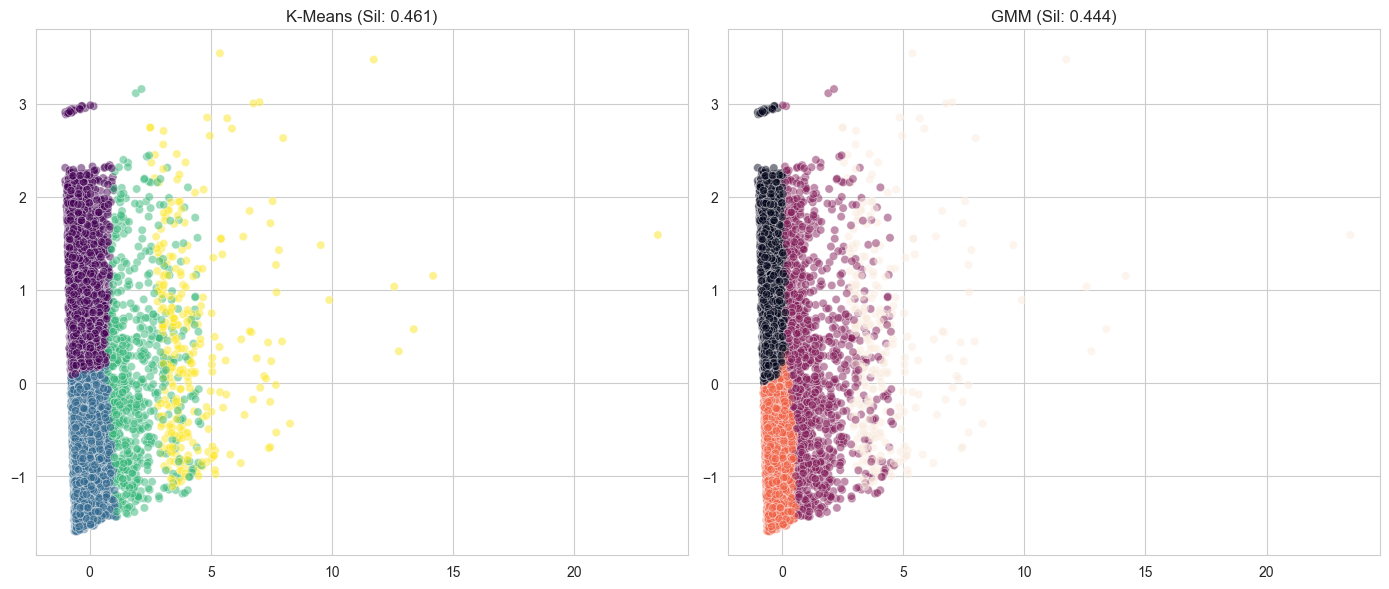

In [16]:
# ==============================================================================
# 6. VISUAL COMPARISON (PCA SIDE-BY-SIDE)
# ==============================================================================
print("[6/10] Visualizing Model Comparison...")

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_sample)

fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Plot K-Means
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=labels_km_sample, palette='viridis', alpha=0.5, ax=ax[0])
ax[0].set_title(f'K-Means (Sil: {sil_km:.3f})')
ax[0].legend().remove()

# Plot GMM
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=labels_gmm_sample, palette='rocket', alpha=0.5, ax=ax[1])
ax[1].set_title(f'GMM (Sil: {sil_gmm:.3f})')
ax[1].legend().remove()

plt.tight_layout()
plt.show()

In [17]:
# ==============================================================================
# 7. STRICT BUSINESS LABELING (Applied to Winner)
# ==============================================================================
print(f"[7/10] Applying Strict Business Labels to {winner_model} Results...")

# 1. Profiling Cluster Pemenang
cluster_profile = rfm.groupby("Cluster")[["Recency", "Frequency", "Monetary"]].mean()

# 2. Ranking Logic (Sama seperti sebelumnya)
cluster_profile["R_rank"] = cluster_profile["Recency"].rank(ascending=False) # Low Recency is good
cluster_profile["F_rank"] = cluster_profile["Frequency"].rank(ascending=True) # High Freq is good
cluster_profile["M_rank"] = cluster_profile["Monetary"].rank(ascending=True) # High Monetary is good

cluster_profile["Score"] = (
    cluster_profile["R_rank"] * 1.0 + 
    cluster_profile["F_rank"] * 1.0 + 
    cluster_profile["M_rank"] * 1.5 
)

cluster_profile = cluster_profile.sort_values("Score", ascending=True) # Sort Terjelek -> Terbaik

# 3. Assign Names (Strict 4 Segments)
segment_mapping = {
    cluster_profile.index[3]: "Champions",
    cluster_profile.index[2]: "Loyal Customers",
    cluster_profile.index[1]: "New / Potential",
    cluster_profile.index[0]: "At Risk / Lost"
}

rfm["Segment"] = rfm["Cluster"].map(segment_mapping)
cluster_profile["Segment_Name"] = cluster_profile.index.map(segment_mapping)

print("\n>>> CLUSTER PROFILING (Ranked):")
print(cluster_profile[["Recency", "Frequency", "Monetary", "Segment_Name"]])

print("\n>>> FINAL SEGMENT DISTRIBUTION:")
print(rfm["Segment"].value_counts())

[7/10] Applying Strict Business Labels to K-Means Results...

>>> CLUSTER PROFILING (Ranked):
            Recency  Frequency    Monetary     Segment_Name
Cluster                                                    
0        388.946214   1.000000  115.785887   At Risk / Lost
1        128.229281   1.000000  115.138749  New / Potential
2        230.776626   1.000000  549.171346  Loyal Customers
3        220.991587   2.103511  274.976170        Champions

>>> FINAL SEGMENT DISTRIBUTION:
Segment
New / Potential    47963
At Risk / Lost     35455
Loyal Customers     6272
Champions           2734
Name: count, dtype: int64


[8/10] Generating Final Segmentation Map...


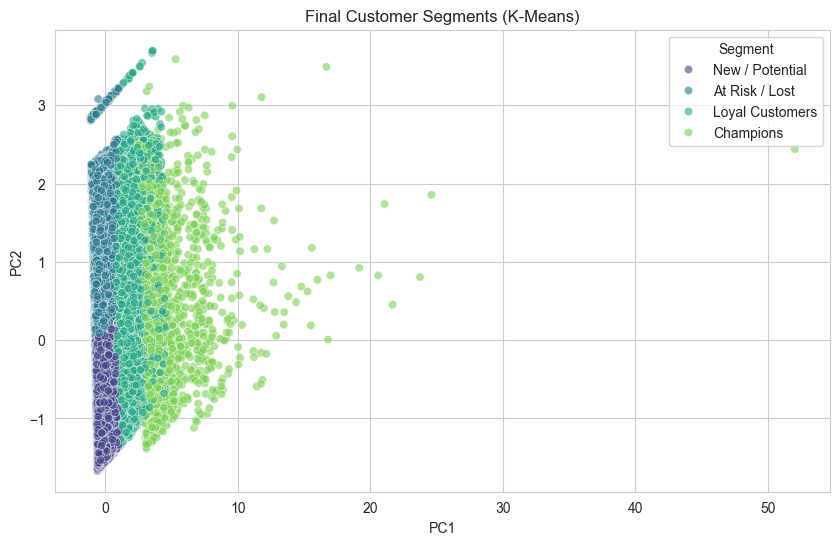


[SUCCESS] Pipeline Completed. Data saved for Decision Engine.


In [18]:
# ==============================================================================
# 8. FINAL VIZ & SAVE
# ==============================================================================
print("[8/10] Generating Final Segmentation Map...")

# Gunakan full data PCA untuk plot final
pca_full = PCA(n_components=2)
comps_full = pca_full.fit_transform(X_scaled)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=comps_full[:,0], y=comps_full[:,1], hue=rfm["Segment"], palette='viridis', alpha=0.6)
plt.title(f"Final Customer Segments ({winner_model})")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

rfm.to_csv("olist_rfm_final_for_engine.csv", index=False)
print("\n[SUCCESS] Pipeline Completed. Data saved for Decision Engine.")